# Popularitieit van een app

Een bedrijf heeft vorige maand een nieuwe app gelanceerd. Ze hebben iedere dag genoteerd hoeveel mensen deze gedownload hebben. Je vindt deze gegevens in “populariteitApp.csv”.

Er zijn in dit geval geen verkeerde of ontbrekende gegevens.  Je zou het bestand dus gemakkelijk moeten kunnen lezen. Je moet wel zorgen dat de kolom "downloads" van het type `float` wordt.


1.	Maak een plot van de gegevens zodat je al wat inzicht krijgt in de data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datum      31 non-null     object 
 1   downloads  31 non-null     float64
dtypes: float64(1), object(1)
memory usage: 624.0+ bytes


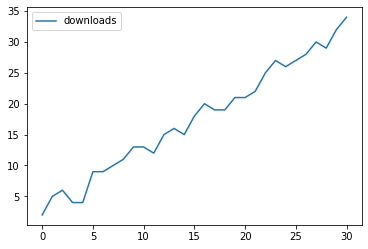

In [ ]:
import numpy as np
import pandas as pd
from scripts.forecast import *

app = pd.read_csv('../datasets/populariteitApp.csv')
app.downloads = app.downloads.astype(float)
app.info()
_ = app.plot()

2.	Kan je de seizoensgrootte vinden?
Tip: gebruik acorr-functie op downloads die je eerst omzet naar Numpy array van floats.

m = [1]


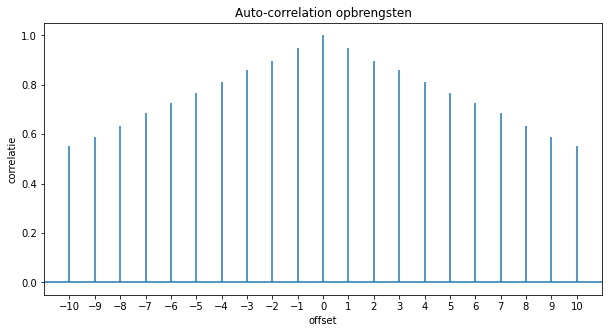

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
lags, acfs, _, _ = ax.acorr(app.downloads)
_ = ax.set_xticks(range(-10, 11))
_ = ax.set_xlabel('offset')
_ = ax.set_ylabel('correlatie')
_ = ax.set_title('Auto-correlation opbrengsten')

# De acorr figuur laat niet echt een seizoen zien.
# Ook visueel is er niet echt een seizoen te zien.

m = find_period(app.downloads)
print('m =', m)
# Periode is 1 maar dit hier geen echte periode, want er is geen herhaling.

3.	Voorspel nu, voor iedere voorspellingsmethode, de drie volgende dagen.  Bereken telkens de MAE, RMSE en de MAPE.

Vervolledig volgende tabel met alle resultaten.

|techniek               | dag 1 | dag 2 | dag 3 | MAE | RMSE | MAPE |
|-----------------------|-------|-------|-------|-----|------|------|
| naief                 | &nbsp;| &nbsp;|&nbsp; |&nbsp;&nbsp;|&nbsp;|
| gemiddelde            | &nbsp;| &nbsp;|&nbsp; |&nbsp;&nbsp;|&nbsp;|
| voortschrijdend(m=5)  | &nbsp;| &nbsp;|&nbsp; |&nbsp;&nbsp;|&nbsp;|
| lin.comb. (m=13)      | &nbsp;| &nbsp;|&nbsp; |&nbsp;&nbsp;|&nbsp;|
| trend                 | &nbsp;| &nbsp;|&nbsp; |&nbsp;&nbsp;|&nbsp;|
| add. decomp. (m=7)    | &nbsp;| &nbsp;|&nbsp; |&nbsp;&nbsp;|&nbsp;|
| multi.decomp. (m=7)   | &nbsp;| &nbsp;|&nbsp; |&nbsp;&nbsp;|&nbsp;|

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

n = app.downloads.size
nn = n + 3
downloads = app.downloads.to_numpy()
# voorspellingen doen voo
naief = predict(downloads, 0, nn, naive)
gemiddelde = predict(downloads, 0, nn, average)
voortschrijdend = predict(downloads, 0, nn, moving_average, 5)
lin_comb = predict(downloads, 0, nn, linear_combination, 13)
trend = create_trend_model(downloads)(np.arange(nn).reshape(-1, 1))
add_model = seasonal_decompose(downloads, model='additive', period=7)
mult_model = seasonal_decompose(downloads, model='multiplicative', period=7)

# voorspellingen voor de komende 3 dagen

# seasonal decompositie voorspellingen hebben twee modellen nodig: regressie en sd model
reg_model = GeneralRegression()
x = np.arange(n)[~np.isnan(add_model.trend)]
y = add_model.trend[~np.isnan(add_model.trend)]
reg_model.fit(x, y)

add_model_pred = seasonal_decomposition_forecast(reg_model, mult_model, 0, nn)
mult_model_pred = seasonal_decomposition_forecast(reg_model, mult_model, 0, nn, method='multiplicative')

dagen = pd.concat([
    pd.Series(naief[n:nn], name='naive'),
    pd.Series(gemiddelde[n:nn], name='gemiddelde'),
    pd.Series(voortschrijdend[n:nn], name='voortschrijdend'),
    pd.Series(lin_comb[n:nn], name='lin_comb'),
    pd.Series(trend[n:nn], name='trend'),
    pd.Series(add_model_pred[n:nn], name='add_model'),
    pd.Series(mult_model_pred[n:nn], name='mult_model')],
    axis=1)
dagen.index = ['dag {}'.format(i) for i in range(1, 4)]

# errors berekenen
errors = pd.concat([
    forecast_errors(downloads, naief[:n], method='naive'),
    forecast_errors(downloads, gemiddelde[:n], method='gemiddelde'),
    forecast_errors(downloads, voortschrijdend[:n], method='voortschrijdend'),
    forecast_errors(downloads, lin_comb[:n], method='lin_comb'),
    forecast_errors(downloads, trend[:n], method='trend'),
    forecast_errors(downloads, add_model_pred[:n], method='add_model'),
    forecast_errors(downloads, mult_model_pred[:n], method='mult_model')])

pd.merge(dagen.transpose(), errors, left_index=True, right_index=True)

,dag 1,dag 2,dag 3,MAE,RMSE,MAPE
naive,34.000000,34.000000,34.000000,1.533333,1.914854,0.119949
gemiddelde,17.483871,17.483871,17.483871,8.202828,9.302767,0.433869
voortschrijdend,30.600000,31.120000,31.344000,3.130769,3.366578,0.183542
lin_comb,36.832063,37.384059,42.098808,1.531631,1.780848,0.048856
trend,33.309677,34.298790,35.287903,1.003642,1.156301,0.104034
add_model,33.988637,34.962483,35.936330,1.158930,1.485943,0.132680
mult_model,32.118228,33.065599,34.012969,1.135491,1.323084,0.110438


4.	lineaire combinatie: welke gewichten vind je?  Welke waarde speelt dus de grootste rol in het voorspellen van de volgende waarde?

In [ ]:
bereken_gewichten(x, 13)

nan

5.	trend: wat is de formule van de regressielijn?

In [ ]:
model = GeneralRegression()
model.fit(np.arange(n), downloads)
print('y = {:2f} * x + {:2f}'.format(model.coef_[1], model.intercept_))

y = 0.989113 * x + 2.647177


6.	additieve decompositie: wat is de formule voor de trendlijn?

In [ ]:
reg_model = GeneralRegression()
x = np.arange(n)[~np.isnan(add_model.trend)]
y = add_model.trend[~np.isnan(add_model.trend)]
reg_model.fit(x, y)
print('y = {:2f} * x + {:2f}'.format(model.coef_[1], model.intercept_))

y = 0.989113 * x + 2.647177


7.	additieve decompositie: wat zijn de waarden voor het weerkerend patroon?

In [ ]:
add_model.seasonal[:7]

8.	multiplicatieve decompositie: wat is de formule voor de trendlijn?

In [ ]:
# zelfde als bij additief model

9.	multiplicatieve decompositie: wat zijn de waarden voor het weerkerend patroon?

In [ ]:
mult_model.seasonal[:7]

10.	welke techniek geeft de beste voorspelling en waarom?

In [ ]:
# De laagste MAPE zit bij lineaire combinatie.  Dat is dus de beste keuze in dit geval.
# Als je echter een andere waarde neemt voor de seizoensgrootte, krijg je veel slechtere resultaten (probeer maar eens).
# Vandaar dat men in de praktijk waarschijnlijk beter multiplicatieve decompositie gebruikt (die ook een lage MAPE heeft).